# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo2_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



We first load the standard packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `pytorch`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification.

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
If you are using Google colab, the packages are already installed.
After you have installed the package, try to import it.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [3]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url, allow_redirects=True)
open(fn, 'wb').write(r.content)

1418242

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [4]:
# TODO
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

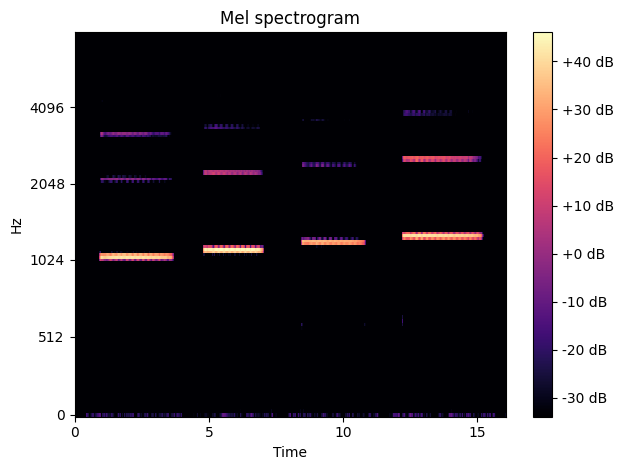

In [5]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, they then segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [6]:
data_dir = ''
import os
fn = os.path.join(data_dir, 'uiowa_train_data.npy')
Xtr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_train_labels.npy')
ytr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_data.npy')
Xts = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_labels.npy')
yts = np.load(fn)

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [7]:
# TODO
ntr = Xtr.shape[0]
nts = Xts.shape[0]
nfeatures = Xtr.shape[1]
nclasses = len(np.unique(ytr))

print(f"Number of training samples: {ntr}")
print(f"Number of test samples: {nts}")
print(f"Number of features per sample: {nfeatures}")
print(f"Number of classes (instruments): {nclasses}")

Number of training samples: 66247
Number of test samples: 14904
Number of features per sample: 120
Number of classes (instruments): 10


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [8]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
Xtr_mean = np.mean(Xtr, axis=0)
Xtr_std = np.std(Xtr, axis=0)

Xtr_scale = (Xtr - Xtr_mean) / Xtr_std
Xts_scale = (Xts - Xtr_mean) / Xtr_std

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb).   create a neural network `model` with:
* `nfeatures` inputs
* `nh=256` hidden units
* `sigmoid` activation
* fully connected layer with `nclasses` outputs
* `nn.Softmax` output
* select the input and output shapes correctly


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the neural network
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return F.softmax(out, dim=1)


# TODO:  Create the model
nh = 256
model = Model(nfeatures, nh, nclasses)

Now print a summary of the model.  You can use the `torchsummary.summary` method as follows:

In [11]:
from torchsummary import summary

# TODO
summary(model, (1, nfeatures))  # put in the input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          30,976
           Sigmoid-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 10]           2,570
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


Next, create `pytorch` `Dataloader` classes from the numpy arrays.  Note that you must use the scaled data `Xtr_scale` and `Xts_scale`.

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# TODO:  Convert your data to PyTorch tensors.
Xtr_torch = torch.from_numpy(Xtr_scale).float()
Xts_torch = torch.from_numpy(Xts_scale).float()
ytr_torch = torch.from_numpy(ytr).long()
yts_torch = torch.from_numpy(yts).long()

# TODO:  Create a TensorDataset
train_dataset = TensorDataset(Xtr_torch, ytr_torch)
test_dataset = TensorDataset(Xts_torch, yts_torch)

# TODO:  Create a DataLoader
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Create the loss and an optimizer.  For the loss, use `nn.CrossEntropyLoss()`.  For the optimizer, use the `optim.Adam` optimizer with a learning rate of 0.001

In [13]:
import torch.optim as optim

# TODO: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Fit the model for 20 epochs using the scaled data for both the training and validation.  In each epoch, save the:
*  average training loss
*  training accuracy
*  test accuracy

Your final test accuracy should be >95%.

In [14]:
# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 20

# Training loop
for epoch in range(epochs):
  # TODO:  Train over epoch
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0
  for (data,target) in train_loader:
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_train += target.size(0)
    correct_train += (predicted == target).sum().item()

  avg_train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct_train / total_train
  loss_history.append(avg_train_loss)
  train_accuracy_history.append(train_accuracy)

  # TODO:  Test over epoch
  model.eval()
  correct_test = 0
  total_test = 0
  with torch.no_grad():
    for (data,target) in test_loader:
      outputs = model(data)
      _, predicted = torch.max(outputs.data, 1)
      total_test += target.size(0)
      correct_test += (predicted == target).sum().item()

  test_accuracy = 100 * correct_test / total_test
  test_accuracy_history.append(test_accuracy)


  # TODO:  Print accuracy
  print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/20, Loss: 1.7426, Train Accuracy: 73.73%, Test Accuracy: 80.43%
Epoch 2/20, Loss: 1.6205, Train Accuracy: 84.64%, Test Accuracy: 85.63%
Epoch 3/20, Loss: 1.6060, Train Accuracy: 85.77%, Test Accuracy: 86.25%
Epoch 4/20, Loss: 1.6016, Train Accuracy: 86.04%, Test Accuracy: 89.74%
Epoch 5/20, Loss: 1.5455, Train Accuracy: 91.97%, Test Accuracy: 92.51%
Epoch 6/20, Loss: 1.5386, Train Accuracy: 92.41%, Test Accuracy: 92.58%
Epoch 7/20, Loss: 1.5369, Train Accuracy: 92.48%, Test Accuracy: 92.67%
Epoch 8/20, Loss: 1.5359, Train Accuracy: 92.53%, Test Accuracy: 92.69%
Epoch 9/20, Loss: 1.5352, Train Accuracy: 92.58%, Test Accuracy: 92.53%
Epoch 10/20, Loss: 1.5344, Train Accuracy: 92.64%, Test Accuracy: 92.32%
Epoch 11/20, Loss: 1.5340, Train Accuracy: 92.64%, Test Accuracy: 92.51%
Epoch 12/20, Loss: 1.5212, Train Accuracy: 94.09%, Test Accuracy: 95.65%
Epoch 13/20, Loss: 1.5023, Train Accuracy: 96.09%, Test Accuracy: 95.63%
Epoch 14/20, Loss: 1.5004, Train Accuracy: 96.20%, Test Accu

Plot the validation accuracy saved in `test_accuracy_history`.  

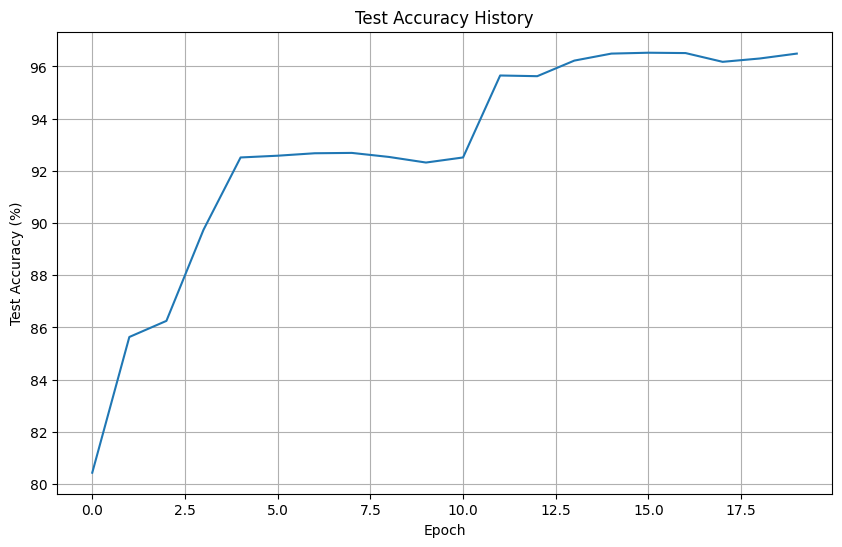

In [15]:
# TODO
plt.figure(figsize=(10, 6))
plt.plot(test_accuracy_history)
plt.title('Test Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.show()

Plot the loss values saved in the `loss_history`.  You should see that the loss is steadily decreasing.  Use the `semilogy` plot.

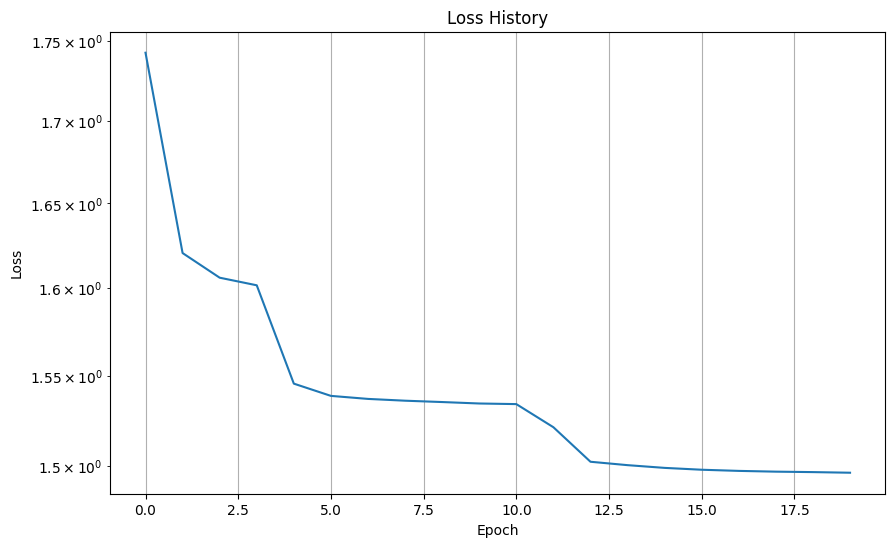

In [16]:
# TODO
plt.figure(figsize=(10, 6))
plt.semilogy(loss_history)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model for 20 epochs
* Save the accuracy and losses

In [17]:
rates = [1e-4, 1e-3, 1e-2]
test_acc_lr = []
loss_hist_lr = []

# TODO
for lr in rates:
    print(f"\nTraining with learning rate: {lr}")

    # TODO:  Create the model
    # model = Model(...)
    model = Model(nfeatures, nh, nclasses)


    # TODO: Define loss function and optimizer
    #   criterion = ...
    #   optimizer = ...
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # Lists to store training and testing accuracy for each epoch
    train_accuracy_history = []
    test_accuracy_history = []
    loss_history = []

    # Number of epochs
    epochs = 20

    # Training loop
    for epoch in range(epochs):

      # TODO:  Train over epoch
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for (data,target) in train_loader:
          optimizer.zero_grad()
          outputs = model(data)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += target.size(0)
          correct_train += (predicted == target).sum().item()

      avg_train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct_train / total_train
      loss_history.append(avg_train_loss)
      train_accuracy_history.append(train_accuracy)

      # TODO:  Test over epoch
      model.eval()
      correct_test = 0
      total_test = 0
      with torch.no_grad():
        for (data,target) in test_loader:
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total_test += target.size(0)
          correct_test += (predicted == target).sum().item()

      test_accuracy = 100 * correct_test / total_test
      test_accuracy_history.append(test_accuracy)


      # TODO:  Print accuracy
      print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

    # TODO:  Save the loss history
    loss_hist_lr.append(loss_history)
    test_acc_lr.append(test_accuracy_history)


Training with learning rate: 0.0001
Epoch 1/20, Loss: 1.9812, Train Accuracy: 55.23%, Test Accuracy: 51.19%
Epoch 2/20, Loss: 1.8351, Train Accuracy: 64.84%, Test Accuracy: 63.32%
Epoch 3/20, Loss: 1.7515, Train Accuracy: 74.02%, Test Accuracy: 71.34%
Epoch 4/20, Loss: 1.6969, Train Accuracy: 78.93%, Test Accuracy: 76.38%
Epoch 5/20, Loss: 1.6757, Train Accuracy: 80.35%, Test Accuracy: 78.34%
Epoch 6/20, Loss: 1.6535, Train Accuracy: 82.54%, Test Accuracy: 82.80%
Epoch 7/20, Loss: 1.6318, Train Accuracy: 84.30%, Test Accuracy: 83.43%
Epoch 8/20, Loss: 1.6251, Train Accuracy: 84.60%, Test Accuracy: 84.20%
Epoch 9/20, Loss: 1.6208, Train Accuracy: 84.86%, Test Accuracy: 84.44%
Epoch 10/20, Loss: 1.6176, Train Accuracy: 85.05%, Test Accuracy: 84.80%
Epoch 11/20, Loss: 1.6151, Train Accuracy: 85.19%, Test Accuracy: 85.13%
Epoch 12/20, Loss: 1.6131, Train Accuracy: 85.34%, Test Accuracy: 85.34%
Epoch 13/20, Loss: 1.6115, Train Accuracy: 85.45%, Test Accuracy: 85.65%
Epoch 14/20, Loss: 1.60

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.  The higher learning rate either plateaus at a lower validation accuracy or is unstable.

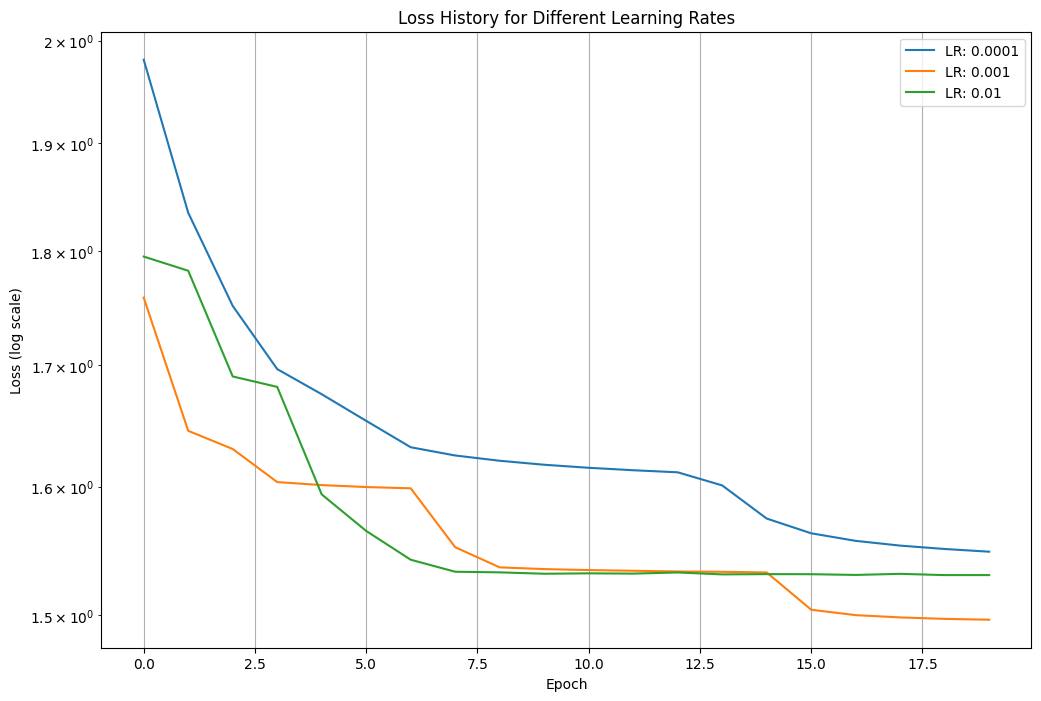

In [18]:
# TODO
plt.figure(figsize=(12, 8))
for i, loss_history in enumerate(loss_hist_lr):
    plt.semilogy(loss_history, label=f'LR: {rates[i]}')
plt.title('Loss History for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True)
plt.show()